# An Introduction to Multi-fidelity Modeling in Emukit

## Overview

A common issue encountered when applying machine learning to environmental sciences and engineering problems is the difficulty or cost required to obtain sufficient data for building robust models.
Possible examples include aerospace and nautical engineering, where it is both infeasible and prohibitively expensive to run a vast number of experiments using the actual vehicle.
Even when there is no physical artifact involved, such as in climate modeling, data may still be hard to obtain when these can only be collected by running an expensive computer experiment, where the time required to acquire an individual data sample restricts the volume of data that can later be used for modeling.

Constructing a reliable model when only few observations are available is challenging, which is why it is common practice to develop <i>simulators</i> of the actual system, from which data points can be more easily obtained.
In engineering applications, such simulators often take the form of Computational Fluid Dynamics (CFD) tools which approximate the behaviour of the true artifact for a given design or configuration.
However, although it is now possible to obtain more data samples, it is highly unlikely that these simulators model the true system exactly; instead, these are expected to contain some degree of bias and/or noise.

From the above, one can deduce that naively combining observations from multiple information sources could result in the model giving biased predictions which do not accurately reflect the true problem.
To this end, <b>multi-fidelity models</b> are designed to augment the limited true observations available with cheaply-obtained approximations in a principled manner.
In such models, observations obtained from the true source are referred to as <i>high-fidelity</i> observations, whereas approximations are denoted as being <i>low-fidelity</i>.
These low-fidelity observations are then systemically combined with the more accurate (but limited) observations in order to predict the high-fidelity output more effectively.
Note than we can generally combine information from multiple lower fidelity sources, which can all be seen as auxiliary tasks in support of a single primary task.

In this notebook, we shall investigate a selection of multi-fidelity models based on Gaussian processes which are readily available in <b style="color:#EB9100">Emukit</b>.
We  start by investigating the traditional linear multi-fidelity model as proposed in [[Kennedy and O'Hagan, 2000]](#kennedy).
Subsequently, we shall illustrate why this model can be unsuitable when the mapping from low to high-fidelity observations is nonlinear, and demonstrate how an alternate model proposed in [[Pedikaris et al. 2017]](#perdikaris) can alleviate this issue.
The examples presented in this notebook can then be easily adapted to a variety of problem settings.

### Navigation

1. [Linear multi-fidelity model](#1.-Linear-multi-fidelity-model)

2. [Nonlinear multi-fidelity model](#2.-Nonlinear-multi-fidelity-model)

3. [References](#3.-References)

In [1]:
# General imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

np.random.seed(20)

## 1. Linear multi-fidelity model

The linear multi-fidelity model proposed in [[Kennedy and O'Hagan, 2000]](#3.-References) is widely viewed as a reference point for all such models.
In this model, the high-fidelity (true) function is modeled as a scaled sum of the low-fidelity function plus an error term:

$$
f_{high}(x) = f_{err}(x) + \rho \,f_{low}(x)
$$

In this equation, $f_{low}(x)$ is taken to be a Gaussian process modeling the outputs of the lower fidelity function, while $\rho$ is a scaling factor indicating the magnitude of the correlation to the high-fidelity data.
Setting this to 0 implies that there is no correlation between observations at different fidelities.
Meanwhile, $f_{err}(x)$ denotes yet another Gaussian process which models the bias term for the high-fidelity data.
Note that $f_{err}(x)$ and $f_{low}(x)$ are assumed to be independent processes which are only related by the equation given above.

>**Note**: While we shall limit our explanation to the case of two fidelities, this set-up can easily be generalized to cater for $T$ fidelities as follows:
>
>$$f_{t}(x) = f_{t}(x) + \rho_{t-1} \,f_{t-1}(x), \quad t=1,\dots, T$$


If the training points are sorted such that the low and high-fidelity points are grouped together:

$$
\begin{pmatrix}
X_{low} \\
X_{high}
\end{pmatrix}
$$

we can express the model as a single Gaussian process having the following prior:

$$
\begin{bmatrix}
f_{low}\left(h\right)\\
f_{high}\left(h\right)
\end{bmatrix}
\sim
GP
\begin{pmatrix}
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\begin{bmatrix}
k_{low} & \rho k_{low} \\
\rho k_{low} & \rho^2 k_{low} + k_{err}
\end{bmatrix}
\end{pmatrix}
$$

### 1.1 Linear multi-fidelity modeling in Emukit

As a first example of how the linear multi-fidelity model implemented in **Emukit** *(emukit.multi_fidelity.models.GPyLinearMultiFidelityModel)* can be used, we shall consider the two-fidelity Forrester function.
This benchmark is frequently used to illustrate the capabilities of multi-fidelity models.

In [2]:
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel

## Generate samples from the Forrester function

high_fidelity = emukit.test_functions.forrester.forrester
low_fidelity = emukit.test_functions.forrester.forrester_low

x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

x_train_l = np.atleast_2d(np.random.rand(12)).T
x_train_h = np.atleast_2d(np.random.permutation(x_train_l)[:6])
y_train_l = low_fidelity(x_train_l)
y_train_h = high_fidelity(x_train_h)

/Users/becklabash/Library/Python/3.8/lib/python/site-packages/GPy/kern/src/symmetric.py:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if symmetry_type is 'odd':
/Users/becklabash/Library/Python/3.8/lib/python/site-packages/GPy/kern/src/symmetric.py:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif symmetry_type is 'even':
 /Users/becklabash/Library/Python/3.8/lib/python/site-packages/GPy/models/mrd.py:307: SyntaxWarning:"is not" with a literal. Did you mean "!="?


The inputs to the models are expected to take the form of ndarrays where the last column indicates the fidelity of the observed points.

Although only the input points, $X$, are augmented with the fidelity level, the observed outputs $Y$ must also be converted to array form.

For example, a dataset consisting of 3 low-fidelity points and 2 high-fidelity points would be represented as follows, where the input is three-dimensional while the output is one-dimensional:

$$
X =
\begin{pmatrix}
x_{low;0}^0 & x_{low;0}^1 & x_{low;0}^2 & 0\\
x_{low;1}^0 & x_{low;1}^1 & x_{low;1}^2 & 0\\
x_{low;2}^0 & x_{low;2}^1 & x_{low;2}^2 & 0\\
x_{high;0}^0 & x_{high;0}^1 & x_{high;0}^2 & 1\\
x_{high;1}^0 & x_{high;1}^1 & x_{high;1}^2 & 1
\end{pmatrix}\quad
Y = \begin{pmatrix}
y_{low;0}\\
y_{low;1}\\
y_{low;2}\\
y_{high;0}\\
y_{high;1}
\end{pmatrix}
$$

A similar procedure must be carried out for obtaining predictions at new test points, whereby the fidelity indicated in the column then indicates the fidelity at which the function must be predicted for a designated point.

For convenience of use, we provide helper methods for easily converting between a list of arrays (ordered from the lowest to the highest fidelity) and the required ndarray representation. This is found in **emukit.multi_fidelity.convert_lists_to_array**.

In [9]:
## Convert lists of arrays to ndarrays augmented with fidelity indicators

from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

X_train, Y_train = convert_xy_lists_to_arrays([x_train_l, x_train_h], [y_train_l, y_train_h])

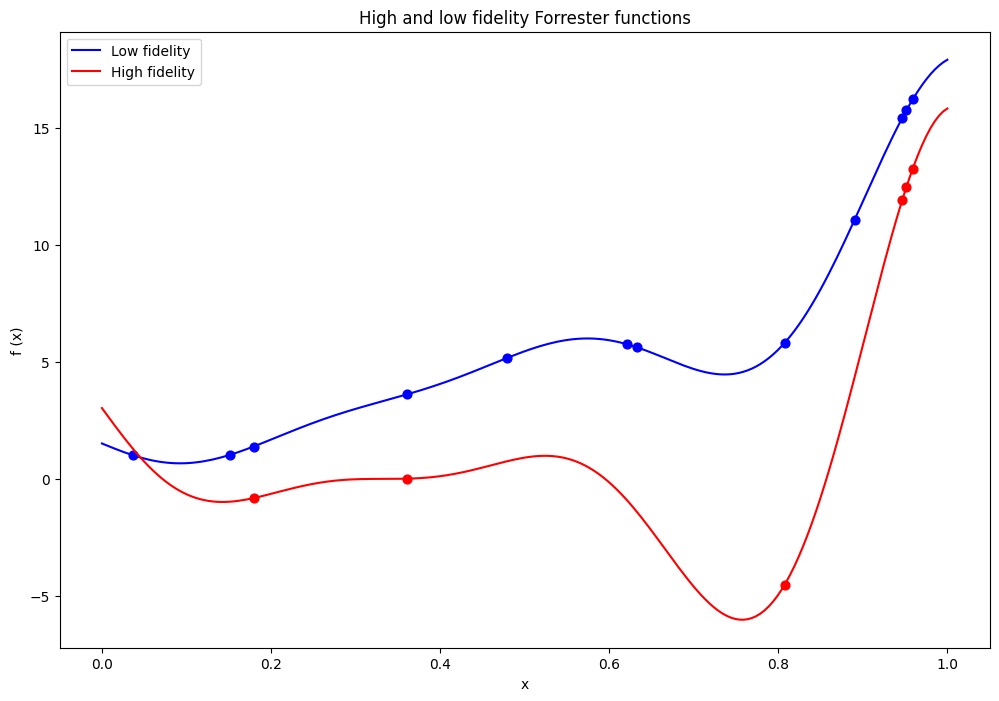

In [4]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, 'b')
plt.plot(x_plot, y_plot_h, 'r')
plt.scatter(x_train_l, y_train_l, color='b', s=40)
plt.scatter(x_train_h, y_train_h, color='r', s=40)
plt.ylabel('f (x)')
plt.xlabel('x')
plt.legend(['Low fidelity', 'High fidelity'])
plt.title('High and low fidelity Forrester functions');

Observe that in the example above we restrict our observations to 12 from the lower fidelity function and only 6 from the high fidelity function.
As we shall demonstrate further below, fitting a standard GP model to the few high fidelity observations is unlikely to result in an acceptable fit, which is why we shall instead consider the linear multi-fidelity model presented in this section.
<br>

Below we fit a linear multi-fidelity model to the available low and high fidelity observations.
Given the smoothness of the functions, we opt to use an <i>RBF</i> kernel for both the bias and correlation components of the model.

>**Note**: The model implementation defaults to a **MixedNoise** noise likelihood whereby there is independent Gaussian noise for each fidelity.
>
>This can be modified upfront using the 'likelihood' parameter in the model constructor, or by updating them directly after the model has been created.
>In the example below, we choose to fix the noise to '0' for both fidelities in order to reflect that the observations are exact.

In [5]:
## Construct a linear multi-fidelity model

kernels = [GPy.kern.RBF(1), GPy.kern.RBF(1)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)


## Wrap the model using the given 'GPyMultiOutputWrapper'

lin_mf_model = model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)

## Fit the model
  
lin_mf_model.optimize()

 /Users/becklabash/Library/Python/3.8/lib/python/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 17.893861456623874
Optimization restart 2/5, f = 17.893861412221348
Optimization restart 3/5, f = 26.353683226409427
Optimization restart 4/5, f = 17.8938613623965
Optimization restart 5/5, f = 17.893860904838107


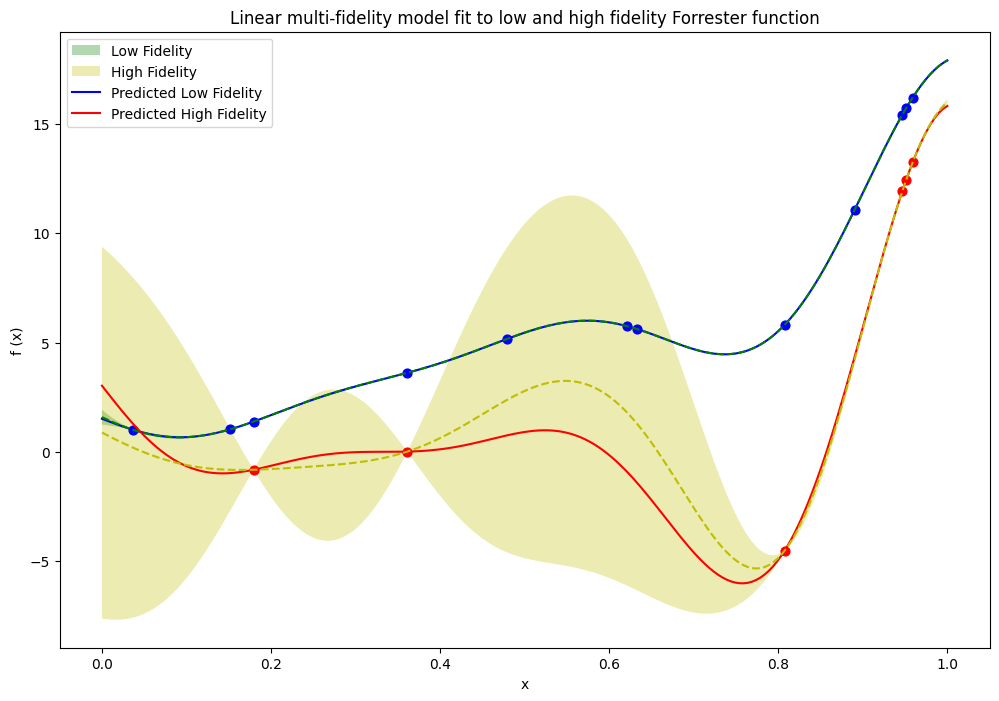

In [6]:
## Convert x_plot to its ndarray representation

X_plot = convert_x_list_to_array([x_plot, x_plot])
X_plot_l = X_plot[:len(x_plot)]
X_plot_h = X_plot[len(x_plot):]

## Compute mean predictions and associated variance

lf_mean_lin_mf_model, lf_var_lin_mf_model = lin_mf_model.predict(X_plot_l)
lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)
hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)


## Plot the posterior mean and variance

plt.figure(figsize=(12, 8))
plt.fill_between(x_plot.flatten(), (lf_mean_lin_mf_model - 1.96*lf_std_lin_mf_model).flatten(), 
                 (lf_mean_lin_mf_model + 1.96*lf_std_lin_mf_model).flatten(), facecolor='g', alpha=0.3)
plt.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='y', alpha=0.3)

plt.plot(x_plot, y_plot_l, 'b')
plt.plot(x_plot, y_plot_h, 'r')
plt.plot(x_plot, lf_mean_lin_mf_model, '--', color='g')
plt.plot(x_plot, hf_mean_lin_mf_model, '--', color='y')
plt.scatter(x_train_l, y_train_l, color='b', s=40)
plt.scatter(x_train_h, y_train_h, color='r', s=40)
plt.ylabel('f (x)')
plt.xlabel('x')
plt.legend(['Low Fidelity', 'High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity'])
plt.title('Linear multi-fidelity model fit to low and high fidelity Forrester function');

The above plot demonstrates how the multi-fidelity model learns the relationship between the low and high-fidelity observations in order to model both of the corresponding functions.
In this example, the posterior mean almost fits the true function exactly, while the associated uncertainty returned by the model is also appropriately small given the good fit.

### 1.2 Comparison to standard GP

In the absence of such a multi-fidelity model, a regular Gaussian process would have been fit exclusively to the high fidelity data.
As illustrated in the figure below, the resulting Gaussian process posterior yields a much worse fit to the data than that obtained by the multi-fidelity model.
The uncertainty estimates are also poorly calibrated.

In [7]:
## Create standard GP model using only high-fidelity data

kernel = GPy.kern.RBF(1)
high_gp_model = GPy.models.GPRegression(x_train_h, y_train_h, kernel)
high_gp_model.Gaussian_noise.fix(0)

## Fit the GP model

high_gp_model.optimize_restarts(5)

## Compute mean predictions and associated variance

hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(x_plot)
hf_std_hf_gp_model = np.sqrt(hf_var_high_gp_model)

Optimization restart 1/5, f = 11.18035236912544
Optimization restart 2/5, f = 11.180352369025673
Optimization restart 3/5, f = 11.180352369163305
Optimization restart 4/5, f = 11.180352374516762
Optimization restart 5/5, f = 11.180352369221604


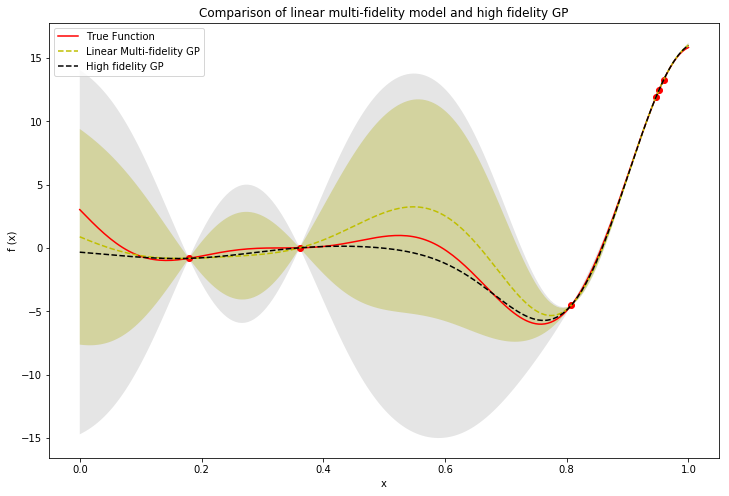

In [8]:
## Plot the posterior mean and variance for the high-fidelity GP model

plt.figure(figsize=(12, 8))

plt.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='y', alpha=0.3)
plt.fill_between(x_plot.flatten(), (hf_mean_high_gp_model - 1.96*hf_std_hf_gp_model).flatten(), 
                 (hf_mean_high_gp_model + 1.96*hf_std_hf_gp_model).flatten(), facecolor='k', alpha=0.1)

plt.plot(x_plot, y_plot_h, color='r')
plt.plot(x_plot, hf_mean_lin_mf_model, '--', color='y')
plt.plot(x_plot, hf_mean_high_gp_model, 'k--')
plt.scatter(x_train_h, y_train_h, color='r')
plt.xlabel('x')
plt.ylabel('f (x)')
plt.legend(['True Function', 'Linear Multi-fidelity GP', 'High fidelity GP'])
plt.title('Comparison of linear multi-fidelity model and high fidelity GP');

## 2. Nonlinear multi-fidelity model

Although the model described above works well when the mapping between the low and high-fidelity functions is linear, several issues may be encountered when this is not the case.
Consider the following example, where the low and high fidelity functions are defined as follows:

$$
f_{low}(x) = sin(8\pi x)
$$

$$
f_{high}(x) = (x - \sqrt{2}) \, f_{low}^2
$$

In [9]:
## Generate data for nonlinear example

high_fidelity = emukit.test_functions.non_linear_sin.nonlinear_sin_high
low_fidelity = emukit.test_functions.non_linear_sin.nonlinear_sin_low

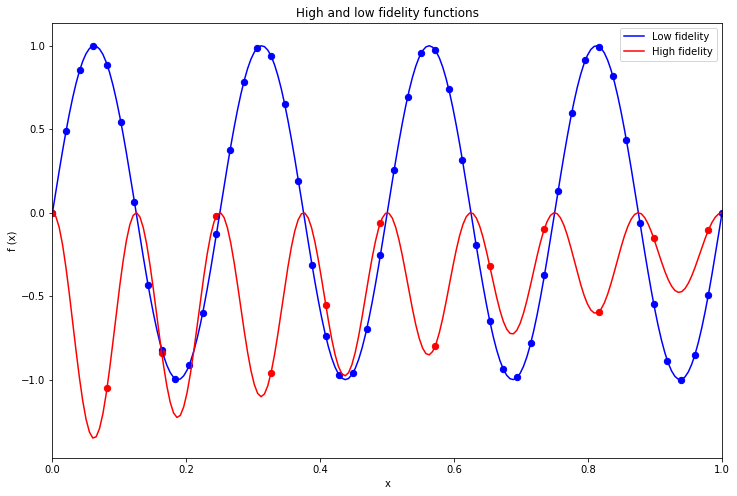

In [10]:
x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

n_low_fidelity_points = 50
n_high_fidelity_points = 14

x_train_l = np.linspace(0, 1, n_low_fidelity_points)[:, None]
y_train_l = low_fidelity(x_train_l)

x_train_h = x_train_l[::4, :]
y_train_h = high_fidelity(x_train_h)

### Convert lists of arrays to ND-arrays augmented with fidelity indicators

X_train, Y_train = convert_xy_lists_to_arrays([x_train_l, x_train_h], [y_train_l, y_train_h])

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, 'b')
plt.plot(x_plot, y_plot_h, 'r')
plt.scatter(x_train_l, y_train_l, color='b', s=40)
plt.scatter(x_train_h, y_train_h, color='r', s=40)
plt.xlabel('x')
plt.ylabel('f (x)')
plt.xlim([0, 1])
plt.legend(['Low fidelity', 'High fidelity'])
plt.title('High and low fidelity functions');

In this case, the mapping between the two functions is nonlinear, as can be observed by plotting the high fidelity observations as a function of the lower fidelity observations.

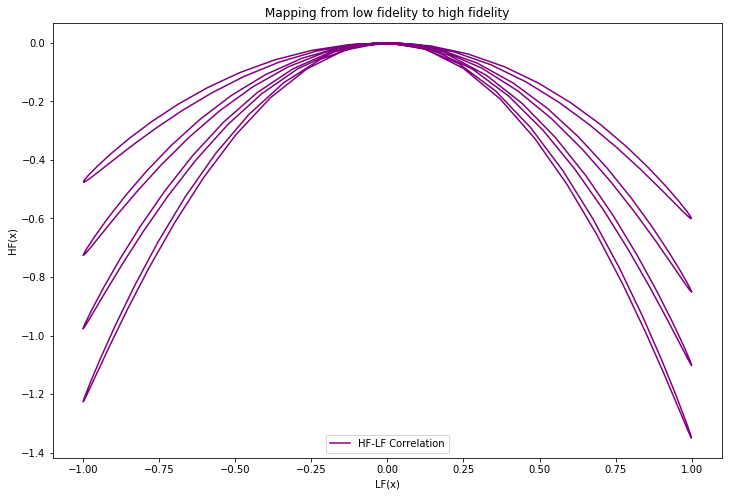

In [11]:
plt.figure(figsize=(12,8))
plt.ylabel('HF(x)')
plt.xlabel('LF(x)')
plt.plot(y_plot_l, y_plot_h, color=colors['purple'])
plt.title('Mapping from low fidelity to high fidelity')
plt.legend(['HF-LF Correlation'], loc='lower center');

### 2.1 Failure of linear multi-fidelity model

Below we fit the linear multi-fidelity model to this new problem and plot the results.

In [12]:
## Construct a linear multi-fidelity model

kernels = [GPy.kern.RBF(1), GPy.kern.RBF(1)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)

lin_mf_model = model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)

## Fit the model
  
lin_mf_model.optimize()

Optimization restart 1/5, f = -228.21429286346074
Optimization restart 2/5, f = 63.367104419164036
Optimization restart 3/5, f = -225.45872076462587
Optimization restart 4/5, f = -225.45872366586323
Optimization restart 5/5, f = -228.2142910153024


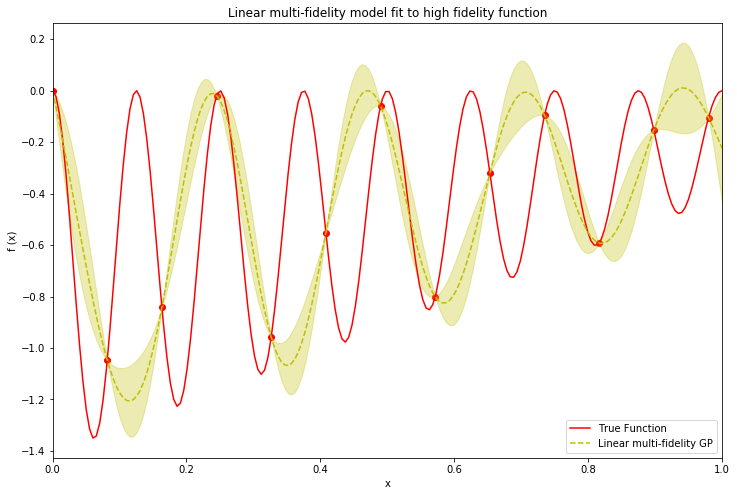

In [13]:
## Convert test points to appropriate representation

X_plot = convert_x_list_to_array([x_plot, x_plot])
X_plot_low = X_plot[:200]
X_plot_high = X_plot[200:]

## Compute mean and variance predictions

hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_high)
hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)


## Compare linear and nonlinear model fits

plt.figure(figsize=(12,8))
plt.plot(x_plot, y_plot_h, 'r')
plt.plot(x_plot, hf_mean_lin_mf_model, '--', color='y')
plt.scatter(x_train_h, y_train_h, color='r')
plt.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), color='y', alpha=0.3)
plt.xlim(0, 1)
plt.xlabel('x')
plt.ylabel('f (x)')
plt.legend(['True Function', 'Linear multi-fidelity GP'], loc='lower right')
plt.title('Linear multi-fidelity model fit to high fidelity function');

As expected, the linear multi-fidelity model was unable to capture the nonlinear relationship between the low and high-fidelity data.
Consequently, the resulting fit of the true function is also poor.

### 2.2 Nonlinear Multi-fidelity model

In view of the deficiencies of the linear multi-fidelity model, a nonlinear multi-fidelity model is proposed in [[Perdikaris et al, 2017]](#3.-References) in order to better capture these correlations.
This nonlinear model is constructed as follows:

$$ f_{high}(x) = \rho( \, f_{low}(x)) + \delta(x) $$

Replacing the linear scaling factor with a non-deterministic function results in a model which can thus capture the nonlinear relationship between the fidelities.


This model is implemented in Emukit as **emukit.multi_fidelity.models.NonLinearModel**.
It is defined in a sequential manner where a Gaussian process model is trained for every set of fidelity data available.
Once again, we manually fix the noise parameter for each model to 0.
The parameters of the two Gaussian processes are then optimized sequentially, starting from the low-fidelity.

In [7]:
## Create nonlinear model

from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

base_kernel = GPy.kern.RBF
kernels = make_non_linear_kernels(base_kernel, 2, X_train.shape[1] - 1)
nonlin_mf_model = NonLinearMultiFidelityModel(X_train, Y_train, n_fidelities=2, kernels=kernels, 
                                              verbose=True, optimization_restarts=5)
for m in nonlin_mf_model.models:
    m.Gaussian_noise.variance.fix(0)
    
nonlin_mf_model.optimize()

Optimization restart 1/5, f = 9.706376913131109
Optimization restart 2/5, f = 9.70637766854816
Optimization restart 3/5, f = 9.706376997425998
Optimization restart 4/5, f = 9.706377231880973
Optimization restart 5/5, f = 9.706376557948742
Optimization restart 1/5, f = 1.0051471095952271
Optimization restart 2/5, f = 0.29026519214920565
Optimization restart 3/5, f = -0.053307930195964026


 /Users/becklabash/Library/Python/3.8/lib/python/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -0.37275044552701875
Optimization restart 5/5, f = 0.23203197986202806


In [8]:
## Compute mean and variance predictions

hf_mean_nonlin_mf_model, hf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot_high)
hf_std_nonlin_mf_model = np.sqrt(hf_var_nonlin_mf_model)

lf_mean_nonlin_mf_model, lf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot_low)
lf_std_nonlin_mf_model = np.sqrt(lf_var_nonlin_mf_model)


## Plot posterior mean and variance of nonlinear multi-fidelity model

plt.figure(figsize=(12,8))
plt.fill_between(x_plot.flatten(), (lf_mean_nonlin_mf_model - 1.96*lf_std_nonlin_mf_model).flatten(), 
                 (lf_mean_nonlin_mf_model + 1.96*lf_std_nonlin_mf_model).flatten(), color='g', alpha=0.3)
plt.fill_between(x_plot.flatten(), (hf_mean_nonlin_mf_model - 1.96*hf_std_nonlin_mf_model).flatten(), 
                 (hf_mean_nonlin_mf_model + 1.96*hf_std_nonlin_mf_model).flatten(), color='y', alpha=0.3)
plt.plot(x_plot, y_plot_l, 'b')
plt.plot(x_plot, y_plot_h, 'r')
plt.plot(x_plot, lf_mean_nonlin_mf_model, '--', color='g')
plt.plot(x_plot, hf_mean_nonlin_mf_model, '--', color='y')
plt.scatter(x_train_h, y_train_h, color='r')
plt.xlabel('x')
plt.ylabel('f (x)')
plt.xlim(0, 1)
plt.legend(['Low Fidelity', 'High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity'])
plt.title('Nonlinear multi-fidelity model fit to low and high fidelity functions');

NameError: name 'X_plot_high' is not defined

Fitting the nonlinear fidelity model to the available data very closely fits the high-fidelity function while also fitting the low-fidelity function exactly.
This is a vast improvement over the results obtained using the linear model.
We can also confirm that the model is properly capturing the correlation between the low and high-fidelity observations by plotting the mapping learned by the model to the true mapping shown earlier.

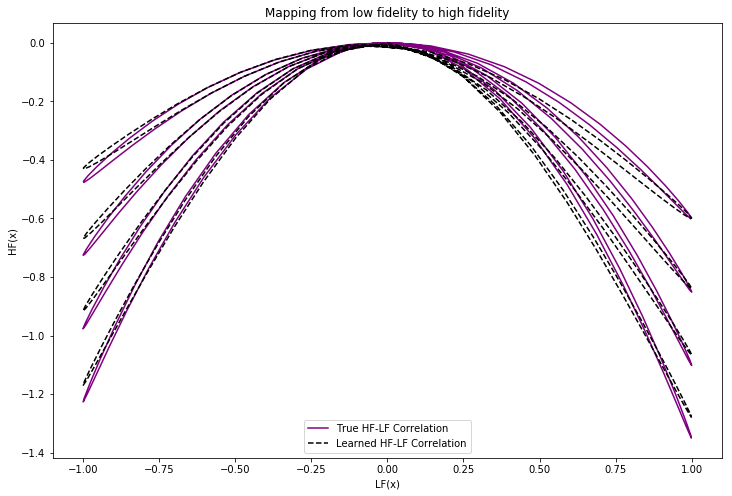

In [16]:
plt.figure(figsize=(12,8))
plt.ylabel('HF(x)')
plt.xlabel('LF(x)')
plt.plot(y_plot_l, y_plot_h, '-', color=colors['purple'])
plt.plot(lf_mean_nonlin_mf_model, hf_mean_nonlin_mf_model, 'k--')
plt.legend(['True HF-LF Correlation', 'Learned HF-LF Correlation'], loc='lower center')
plt.title('Mapping from low fidelity to high fidelity');

## 3. References

- Kennedy, M.C. and O'Hagan, A., 2000. *Predicting the output from a complex computer code when fast approximations are available.* Biometrika, 87(1), pp.1-13.

- Perdikaris, P., Raissi, M., Damianou, A., Lawrence, N.D. and Karniadakis, G.E., 2017. *Nonlinear information fusion algorithms for data-efficient multi-fidelity modelling.* Proc. R. Soc. A, 473(2198), p.20160751.